![Banner](https://i.imgur.com/a3uAqnb.png)

# Image Translation using Conditional GAN (Pix2Pix) - Homework Assignment

In this homework, you will implement a **Conditional Image-to-Image GAN** for translating edge images to shoe images. This is based on the **Pix2Pix** architecture that learns to map from one image domain to another.

## 📌 Project Overview
- **Task**: Edge-to-Shoe image translation
- **Architecture**: Conditional GAN with U-Net Generator and PatchGAN Discriminator
- **Dataset**: Edge2Shoes dataset (provided)
- **Goal**: Generate realistic shoe images from edge sketches

![Pix2Pix](https://i.imgur.com/EV0Mp4U.jpeg)


## 📚 Learning Objectives
By completing this assignment, you will:
- Understand conditional GANs and image-to-image translation
- Implement U-Net architecture with skip connections
- Build a PatchGAN discriminator
- Learn about combined loss functions (adversarial + L1)
- Practice training GANs with proper loss balancing

## 1️⃣ Dataset Setup (PROVIDED)

The Edge2Shoes dataset has been downloaded and prepared for you. The dataset structure is as follows:
- `train/` folder contains training images
- `val/` folder contains validation images
- Each image contains edge sketch (left half) and corresponding shoe (right half)


In [ ]:
import kagglehub
import os

# Dataset already downloaded and prepared
path = kagglehub.dataset_download("balraj98/edges2shoes-dataset")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/edges2shoes-dataset


## 2️⃣ Import Libraries and Configuration

**Task**: Import all necessary libraries and set up configuration parameters.

**Requirements**:
- Import PyTorch, torchvision, and related libraries
- Import matplotlib, PIL, numpy, and other utilities
- Set random seeds for reproducibility
- Configure hyperparameters with reasonable values

In [ ]:
# TODO: Import all necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import os

# TODO: Set random seeds for reproducibility (use seed=42)
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# TODO: Check device availability and print
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# TODO: Define configuration parameters, feel free to change them as you see fit.
IMG_SIZE = 128  # Image size
BATCH_SIZE = 16  # Batch size

LEARNING_RATE = 0.0002  # Learning rate

generator_lr = 0.0002
discriminator_lr = 0.0001

BETA1 = 0.5  # Adam optimizer beta1
BETA2 = 0.999  # Adam optimizer beta2
LAMBDA_L1 = 100  # Weight for L1 loss
NUM_EPOCHS = 5  # Number of training epochs

Using device: cuda


Remark: To make the generator have more chance to learn (the discriminator here is too strong and smart within few iterations), we didn't use the original same LEARNING_RATE for both of them and set their learning rates differently.

## 3️⃣ Custom Dataset Class

**Task**: Create a custom dataset class that handles the Edge2Shoes data format.

**Requirements**:
- Split each image into left half (edge) and right half (shoe)
- Apply transformations to both images
- Return edge image as input and shoe image as target


In [ ]:
# TODO: Create EdgeShoeDataset class inheriting from torch.utils.data.Dataset
class EdgeShoeDataset(Dataset):
# TODO: In __init__:
    def __init__(self, root_dir, transform=None):
#       - Store root_dir and transform
        self.root_dir = root_dir
        self.transform = transform
#       - Get list of all .jpg files
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith('.jpg')]
# TODO: Implement __len__ to return number of images
    def __len__(self):
        return len(self.image_files)
# TODO: Implement __getitem__ to:
#       - Load image and convert to RGB
    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_path).convert('RGB') # Ensure RGB format
#       - Split into left half (edge) and right half (shoe)
        width, height = image.size
        left_half = image.crop((0, 0, width // 2, height))
        right_half = image.crop((width // 2, 0, width, height))
#       - Apply transforms if provided
        if self.transform:
            left_half = self.transform(left_half)
            right_half = self.transform(right_half)
#       - Return (edge_img, shoe_img) tuple
        return left_half, right_half

## 4️⃣ Data Preprocessing and Loading

**Task**: Set up data transformations and create data loaders.

**Requirements**:
- Resize images to target size (128x128)
- Convert to tensors and normalize to [-1, 1] range
- Create train and validation datasets and loaders

In [ ]:
# TODO: Define transforms using transforms.Compose:
transforms_compose = transforms.Compose([
#       - Resize to (IMG_SIZE, IMG_SIZE)
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
#       - ToTensor()
    transforms.ToTensor(),
#       - Normalize with mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# TODO: Create train_dataset using EdgeShoeDataset with train folder
train_dataset = EdgeShoeDataset(root_dir=os.path.join(path, 'train'), transform=transforms_compose)
# TODO: Create val_dataset using EdgeShoeDataset with val folder
val_dataset = EdgeShoeDataset(root_dir=os.path.join(path, 'val'), transform=transforms_compose)

# TODO: Create train_loader and val_loader with DataLoader
#       - Use appropriate batch_size and shuffle settings
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


# TODO: Print dataset sizes
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

# TODO: Test by loading one sample and printing shapes
edge_img, shoe_img = next(iter(train_loader))
print(f"Shape of one edge image batch: {edge_img.shape}")
print(f"Shape of one shoe image batch: {shoe_img.shape}")

Training dataset size: 49825
Validation dataset size: 200
Shape of one edge image batch: torch.Size([16, 3, 128, 128])
Shape of one shoe image batch: torch.Size([16, 3, 128, 128])



## 5️⃣ Generator Network (U-Net Architecture)

**Task**: Implement a U-Net generator with encoder-decoder structure and skip connections.

**Requirements**:
- Encoder: Progressive downsampling using Conv2d layers
- Decoder: Progressive upsampling using ConvTranspose2d layers  
- Skip connections between corresponding encoder-decoder layers
- Final output uses Tanh activation for [-1,1] range

In [ ]:
# TODO: Create Generator class inheriting from nn.Module
class Generator(nn.Module):
# TODO: In __init__(self, in_channels=3, out_channels=3):
    def __init__(self, in_channels=3, out_channels=3):
        super(Generator, self).__init__()

#       Build Encoder (downsampling):
#       - Layer 1: Conv2d(3, 64, 4, 2, 1) + LeakyReLU (no BatchNorm)
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, 4, 2, 1),
            nn.LeakyReLU(0.2)
        ) # 64x64
#       - Layer 2: Conv2d(64, 128, 4, 2, 1) + BatchNorm2d + LeakyReLU
        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2)
        ) # 32x32
#       - Layer 3: Conv2d(128, 256, 4, 2, 1) + BatchNorm2d + LeakyReLU
        self.enc3 = nn.Sequential(
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2)
        ) # 16x16
#       - Layer 4: Conv2d(256, 512, 4, 2, 1) + BatchNorm2d + LeakyReLU
        self.enc4 = nn.Sequential(
            nn.Conv2d(256, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2)
        ) # 8x8
#       - Layer 5: Conv2d(512, 512, 4, 2, 1) + BatchNorm2d + LeakyReLU
        self.enc5 = nn.Sequential(
            nn.Conv2d(512, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2)
        ) # 4x4
#       - Layer 6: Conv2d(512, 512, 4, 2, 1) + BatchNorm2d + LeakyReLU (bottleneck)
        self.bottleneck = nn.Sequential(
            nn.Conv2d(512, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2)
        ) # 2x2

#       Build Decoder (upsampling with skip connections):
#       - Layer 1: ConvTranspose2d(512, 512, 4, 2, 1) + BatchNorm2d + Dropout + ReLU
        self.dec1 = nn.Sequential(
            nn.ConvTranspose2d(512, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.Dropout(0.5),
            nn.ReLU()
        ) # 4x4 - receives input from bottleneck (512) -> outputs 512
#       - Layer 2: ConvTranspose2d(1024, 512, 4, 2, 1) + BatchNorm2d + Dropout + ReLU
        self.dec2 = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, 4, 2, 1), # Input from dec1(512) + enc5(512) = 1024
            nn.BatchNorm2d(512),
            nn.Dropout(0.5),
            nn.ReLU()
        ) # 8x8
#       - Layer 3: ConvTranspose2d(1024, 256, 4, 2, 1) + BatchNorm2d + ReLU
        self.dec3 = nn.Sequential(
            nn.ConvTranspose2d(1024, 256, 4, 2, 1), # Input from dec2(512) + enc4(512) = 1024
            nn.BatchNorm2d(256),
            nn.ReLU()
        ) # 16x16
#       - Layer 4: ConvTranspose2d(512, 128, 4, 2, 1) + BatchNorm2d + ReLU
        self.dec4 = nn.Sequential(
            nn.ConvTranspose2d(512, 128, 4, 2, 1), # Input from dec3(256) + enc3(256) = 512
            nn.BatchNorm2d(128),
            nn.ReLU()
        ) # 32x32
#       - Layer 5: ConvTranspose2d(256, 64, 4, 2, 1) + BatchNorm2d + ReLU
        self.dec5 = nn.Sequential(
            nn.ConvTranspose2d(256, 64, 4, 2, 1), # Input from dec4(128) + enc2(128) = 256
            nn.BatchNorm2d(64),
            nn.ReLU()
        ) # 64x64
#       - Final: ConvTranspose2d(128, 3, 4, 2, 1) + Tanh
        self.final = nn.Sequential(
            nn.ConvTranspose2d(128, out_channels, 4, 2, 1), # Input from dec5(64) + enc1(64) = 128
            nn.Tanh()
        ) # 128x128

# TODO: In forward(self, x):
    def forward(self, x):
#       - Pass through encoder, save intermediate outputs
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        e4 = self.enc4(e3)
        e5 = self.enc5(e4)

        # Bottleneck
        bottleneck = self.bottleneck(e5)

#       - Pass through decoder, concatenating skip connections
        d1 = self.dec1(bottleneck)
        d1 = torch.cat((d1, e5), 1) # Skip connection from e5

        d2 = self.dec2(d1)
        d2 = torch.cat((d2, e4), 1) # Skip connection from e4

        d3 = self.dec3(d2)
        d3 = torch.cat((d3, e3), 1) # Skip connection from e3

        d4 = self.dec4(d3)
        d4 = torch.cat((d4, e2), 1) # Skip connection from e2

        d5 = self.dec5(d4)
        d5 = torch.cat((d5, e1), 1) # Skip connection from e1

        # Final output
        output = self.final(d5)

#       - Return final output
        return output

# TODO: Initialize generator and print parameter count
generator = Generator().to(device)
print("Generator parameter count:", sum(p.numel() for p in generator.parameters() if p.requires_grad))

# TODO: Test with random input to verify output shape
random_input = torch.randn(1, 3, IMG_SIZE, IMG_SIZE).to(device)
output = generator(random_input)
print("Output shape of Generator:", output.shape)

Generator parameter count: 29248515
Output shape of Generator: torch.Size([1, 3, 128, 128])



## 6️⃣ Discriminator Network (PatchGAN)

**Task**: Implement a PatchGAN discriminator that classifies image patches as real/fake.

**Requirements**:
- Accept concatenated input (edge + shoe = 6 channels)
- Use strided convolutions for downsampling
- Output a patch-wise classification matrix (not single value)
- Use LeakyReLU activations

| Feature | Standard Discriminator | PatchGAN Discriminator (Your provided code) |
| :---------------- | :---------------------------------------------------------- | :------------------------------------------------------------------------- |
| **Core Structure** | Convolutional layers + Flatten + Fully connected layer (Linear) | Fully Convolutional Network, no fully connected layers |
| **Final Output** | A scalar value (Usually a probability between 0 and 1 obtained after Sigmoid activation) | An N x N feature map (e.g., 14x14) |
| **Judgment Target** | Gives an overall "real/fake" judgment for the entire image. | Gives a "real/fake" judgment for each local region (Patch) in the image. |
| **Working Method** | Like an art critic, who, after reviewing a complete painting, gives an overall judgment: "This painting is fake" or "This painting is a masterpiece." | Like a pixel-level inspector, who checks the painting block by block and points out: "This stroke is very real" or "That color is a bit fake." |
| **Number of Parameters** | Usually more, because the final fully connected layer can be very large. | Relatively few, more efficient. |

| Feature | Regular CNN | Fully Convolutional Network (FCN) |
| :---------------- | :---------------------------------------------------------- | :------------------------------------------------------------------------- |
| **Final Layer** | Usually includes fully connected layers | All layers are convolutional layers (no fully connected layers) |
| **Output Format** | Fixed-size vector (e.g., class probabilities) | Feature map/segmentation map related to input dimensions (pixel-level) |
| **Core Task** | Image classification, object detection (image-level prediction) | Semantic segmentation (pixel-level prediction) |
| **Spatial Information** | Spatial information is lost at the fully connected layer | Spatial information is preserved (through convolution and upsampling) |
| **Input Size** | Usually requires fixed input size (because of fully connected layers) | Can process input images of arbitrary size |

FCN之所以能实现像素级分类，是因为它：

1. 保持了全程的卷积操作，不丢失空间信息。

2. 通过上采样将低分辨率的语义特征图恢复到原始图像尺寸。

*Remark: 我们这边的PatchGAN没有上采样，因为我们只需要对图片分割成小patch、判断真实性即可。*

3. 利用跳跃连接将编码器中不同层级的特征（包含丰富空间细节的浅层特征和包含高级语义的深层特征）进行融合，从而在保证语义准确性的同时，大大提升了分割结果的边界精度。

**PatchGAN 将一个对整张图片的判别任务，分解为了多个对局部小块的判别任务，从而将损失施加在图像的各个空间位置上，极大地提升了生成图像的细节质量和真实感。**

In [ ]:
# TODO: Create Discriminator class inheriting from nn.Module
class Discriminator(nn.Module):
# TODO: In __init__(self, in_channels=6):  # 3 for edge + 3 for shoe
    def __init__(self, in_channels=6):  # 3 for edge + 3 for shoe
        super(Discriminator, self).__init__()
#       Build discriminator layers:
#       - Layer 1: Conv2d(6, 64, 4, 2, 1) + LeakyReLU (no BatchNorm)
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, 4, 2, 1, padding_mode='reflect'),
            nn.LeakyReLU(0.2)
        ) # 64x64
#       - Layer 2: Conv2d(64, 128, 4, 2, 1) + BatchNorm2d + LeakyReLU
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, 4, 2, 1, padding_mode='reflect'),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2)
        ) # 32x32
#       - Layer 3: Conv2d(128, 256, 4, 2, 1) + BatchNorm2d + LeakyReLU
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, 4, 2, 1, padding_mode='reflect'),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2)
        ) # 16x16
#       - Layer 4: Conv2d(256, 512, 4, 1, 1) + BatchNorm2d + LeakyReLU
        self.layer4 = nn.Sequential(
            nn.Conv2d(256, 512, 4, 1, 1, padding_mode='reflect'),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2)
        ) # 15x15 (kernel 4, stride 1, padding 1 results in (N-4+2*1)/1 + 1 = N-1 sized output)
#       - Final: Conv2d(512, 1, 4, 1, 1) (no activation)
        self.final = nn.Conv2d(512, 1, 4, 1, 1, padding_mode='reflect') # 14x14
        # self.final 是一个 1x1 的卷积核，输出通道为 1。它将 512 个通道的特征图压缩成一个单通道的特征图。这是PatchGAN的核心。

# TODO: In forward(self, img_A, img_B):
    def forward(self, img_A, img_B):
#       - Concatenate img_A and img_B along channel dimension
        x = torch.cat([img_A, img_B], dim=1) # Concatenate channels
#       - Pass through discriminator layers
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        patch_predictions = self.final(x)
#       - Return patch predictions
        return patch_predictions

# TODO: Initialize discriminator and print parameter count
discriminator = Discriminator().to(device)
print("Discriminator parameter count:", sum(p.numel() for p in discriminator.parameters() if p.requires_grad))

# TODO: Test with random inputs to verify output shape
random_img_A = torch.randn(1, 3, IMG_SIZE, IMG_SIZE).to(device)
random_img_B = torch.randn(1, 3, IMG_SIZE, IMG_SIZE).to(device)
output_discriminator = discriminator(random_img_A, random_img_B)
print("Output shape of Discriminator:", output_discriminator.shape)

Discriminator parameter count: 2769601
Output shape of Discriminator: torch.Size([1, 1, 14, 14])


## 7️⃣ Loss Functions and Optimizers

**Task**: Set up loss functions and optimizers for GAN training.

**Requirements**:
- Use appropriate loss functions for adversarial and reconstruction objectives
- Initialize optimizers with given hyperparameters
- Implement weight initialization for stable training

**如何计算判别器的loss？**

1. *创建目标标签*: 当输入是 真实图片对 (real_A, real_B) 时，我们希望判别器对每个 Patch 都输出“真”。因此，我们创建一个与判别器输出形状相同的全 1 的张量作为目标标签 (torch.ones(1, 1, 14, 14))。

2. *创建目标标签*: 当输入包含 伪造图片 (real_A, fake_B) 时，我们希望判别器对每个 Patch 都输出“假”。因此，我们创建一个全 0 的张量作为目标标签 (torch.zeros(1, 1, 14, 14))。

3. *计算损失*: 使用像 BCEWithLogitsLoss 这样的损失函数，来计算判别器的 14x14 输出矩阵和目标标签矩阵之间的差异。

4. *反向传播*: 这个损失会作用于矩阵中的每一个点，然后反向传播，更新判别器或生成器的权重。

In [ ]:
# TODO: Define loss functions:
#       - criterion_GAN = nn.BCEWithLogitsLoss() for adversarial loss
criterion_GAN = nn.BCEWithLogitsLoss()
#       - criterion_L1 = nn.L1Loss() for reconstruction loss
criterion_L1 = nn.L1Loss()


# TODO: Create optimizers:
#       - optimizer_G for generator with Adam(lr=LEARNING_RATE, betas=(BETA1, BETA2))
optimizer_G = optim.Adam(generator.parameters(), lr=generator_lr, betas=(BETA1, BETA2))
#       - optimizer_D for discriminator with Adam(lr=LEARNING_RATE, betas=(BETA1, BETA2))
optimizer_D = optim.Adam(discriminator.parameters(), lr=discriminator_lr, betas=(BETA1, BETA2))


# TODO: Implement weights_init(m) function:
def weights_init(m):
    classname = m.__class__.__name__
#       - For Conv layers: init with normal_(mean=0.0, std=0.02)
#       - For BatchNorm layers: weight normal_(1.0, 0.02), bias constant_(0)
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


# TODO: Apply weights_init to both generator and discriminator
generator.apply(weights_init)
discriminator.apply(weights_init)

print("Loss functions and optimizers initialized, and weights applied.")

Loss functions and optimizers initialized, and weights applied.


## 8️⃣ Training Loop

**Task**: Implement the main GAN training loop with alternating updates.

**Requirements**:
- Train generator to fool discriminator and match target images
- Train discriminator to distinguish real from generated images
- Balance adversarial loss with L1 reconstruction loss
- Track and display training progress

**L1 损失保证“画得对”：确保生成图像的内容和结构与目标图像基本一致。**

**GAN 损失保证“画得真”：确保生成图像的纹理、细节和整体风格看起来真实、清晰，而不是模糊的。**

**nn.L1Loss (重建损失 | Reconstruction Loss)**

这个损失函数也常被称为像素级损失 (Per-ceptual Loss)。

作用: 它逐个像素地计算生成图像和真实目标图像之间的绝对差值之和

为什么需要它?

1. 保证内容准确性: 对抗损失只关心“看起来真不真”，但它不保证生成的内容就是你想要的。例如，从一只鞋的线稿生成图像，GAN 损失可能会生成一只非常逼真的其他款式的鞋。L1 损失通过直接比较像素，强制生成器产出的图像在结构、轮廓和颜色上与目标图像保持一致，确保了翻译的准确性。

2. 比 L2 Loss 更少模糊: 与 L2 损失 (均方误差) 相比，L1 损失对异常值不那么敏感，并且在图像生成任务中被证明能产生更清晰的边缘，减少模糊感。

**nn.BCEWithLogitsLoss (对抗损失 | Adversarial Loss)**

这个损失函数是 GAN (生成对抗网络) 的核心。

作用: 它驱动生成器 (Generator) 和判别器 (Discriminator) 之间的对抗游戏。

1. 对判别器 (D): 训练 D 能够准确地区分“真实的图片对”和“伪造的图片对”。当输入为真图片时，D 的输出应趋近于1；当输入为假图片时，D 的输出应趋近于0。

2. 对生成器 (G): 训练 G 生成能够“欺骗”D 的图片。G 的目标是让它生成的图片经过 D 判断后，得到的结果越接近1越好。

为什么需要它?

1. 提升真实感和清晰度: 单独使用像素级别的损失（如 L1 或 L2）往往会产生模糊的图像，因为模型会倾向于学习所有可能输出的“平均值”来最小化像素误差。而对抗损失则强迫生成器学习真实图像的数据分布，产生更锐利、包含更多高频细节的图像，因为“模糊”本身就是一种很容易被判别器识别的“假”的特征。

In [ ]:
# TODO: Create training loop for NUM_EPOCHS:

# TODO: Track losses and display training progress
#       - Lists to store losses for plotting
g_losses = []
d_losses = []

print(f"Starting training for {NUM_EPOCHS} epochs...")

#       For each batch in train_loader:
for epoch in range(NUM_EPOCHS):
    for i, (edge_imgs, real_shoes) in enumerate(train_loader):
#       - Move edge_imgs and real_shoes to device
        edge_imgs = edge_imgs.to(device)
        real_shoes = real_shoes.to(device)
#       - Get batch_size
        batch_size = edge_imgs.size(0)

#       ---------------------
#       Train Discriminator:
#       ---------------------
        optimizer_D.zero_grad()

#       - Get prediction on real pair (edge_imgs, real_shoes)
        real_pair = torch.cat((edge_imgs, real_shoes), 1)
        pred_real = discriminator(edge_imgs, real_shoes)
        # We want the discriminator to predict 1 (real) for real pairs
#       - Calculate loss for real (should predict 1)
        label_real = torch.ones_like(pred_real, device=device)
        loss_D_real = criterion_GAN(pred_real, label_real)

        # Discriminator loss for fake images
        # Generate fake shoes using the generator
        fake_shoes = generator(edge_imgs)
#       - Get prediction on fake pair (edge_imgs, fake_shoes.detach())
        fake_pair = torch.cat((edge_imgs, fake_shoes.detach()), 1)
        pred_fake = discriminator(edge_imgs, fake_shoes.detach())
        # We want the discriminator to predict 0 (fake) for fake pairs
#       - Calculate loss for fake (should predict 0)
        label_fake = torch.zeros_like(pred_fake, device=device)
        loss_D_fake = criterion_GAN(pred_fake, label_fake)

#       - Total loss = (real_loss + fake_loss) / 2
        loss_D = (loss_D_real + loss_D_fake) / 2

#       - Backpropagate and update discriminator
        loss_D.backward()
        optimizer_D.step()

#       ---------------------
#       Train Generator:
#       ---------------------
        optimizer_G.zero_grad()
# TODO: Use appropriate label creation for discriminator training

#       - Generate fake shoes (these are already generated above, but we use
#       them here with the generator's graph attached for backprop)
        fake_shoes = generator(edge_imgs)

#       - Get discriminator prediction on (edge_imgs, fake_shoes)
        pred_fake_for_G = discriminator(edge_imgs, fake_shoes)
#       - Calculate adversarial loss (try to fool discriminator)
        loss_G_GAN = criterion_GAN(pred_fake_for_G, label_real) # Target is 1 for Generator

#       - Calculate L1 loss between fake_shoes and real_shoes(for Generator)
        loss_G_L1 = criterion_L1(fake_shoes, real_shoes)

#       - Total loss = adversarial_loss + LAMBDA_L1 * L1_loss
        loss_G = loss_G_GAN + LAMBDA_L1 * loss_G_L1

#       - Backpropagate and update generator
        loss_G.backward()
        optimizer_G.step()

#       - Print training statistics
        if (i+1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Step [{i+1}/{len(train_loader)}], "
                  f"D Loss: {loss_D.item():.4f}, G Loss: {loss_G.item():.4f} "
                  f"(GAN: {loss_G_GAN.item():.4f}, L1: {loss_G_L1.item():.4f})")

        # Store losses for plotting
        d_losses.append(loss_D.item())
        g_losses.append(loss_G.item())

print("Training finished.")

Starting training for 5 epochs...
Epoch [1/5], Step [100/3115], D Loss: 0.4431, G Loss: 22.2752 (GAN: 1.9948, L1: 0.2028)
Epoch [1/5], Step [200/3115], D Loss: 0.3044, G Loss: 22.6678 (GAN: 2.2335, L1: 0.2043)
Epoch [1/5], Step [300/3115], D Loss: 0.7637, G Loss: 18.9288 (GAN: 1.7551, L1: 0.1717)
Epoch [1/5], Step [400/3115], D Loss: 0.5677, G Loss: 21.8247 (GAN: 1.7742, L1: 0.2005)
Epoch [1/5], Step [500/3115], D Loss: 0.2606, G Loss: 18.8246 (GAN: 1.3398, L1: 0.1748)
Epoch [1/5], Step [600/3115], D Loss: 0.4433, G Loss: 15.1205 (GAN: 1.2163, L1: 0.1390)
Epoch [1/5], Step [700/3115], D Loss: 0.5016, G Loss: 17.4899 (GAN: 1.6655, L1: 0.1582)
Epoch [1/5], Step [800/3115], D Loss: 0.4181, G Loss: 17.5425 (GAN: 1.2413, L1: 0.1630)
Epoch [1/5], Step [900/3115], D Loss: 0.3426, G Loss: 17.8206 (GAN: 1.9401, L1: 0.1588)
Epoch [1/5], Step [1000/3115], D Loss: 0.4334, G Loss: 19.4688 (GAN: 1.4079, L1: 0.1806)
Epoch [1/5], Step [1100/3115], D Loss: 0.6537, G Loss: 15.6519 (GAN: 0.8936, L1: 0.14


## 9️⃣ Evaluation and Visualization

**Task**: Evaluate your trained model and visualize results.

**Requirements**:
- Generate shoes from validation edge images
- Compare with ground truth shoes
- Create side-by-side visualizations



Visualizing validation results...


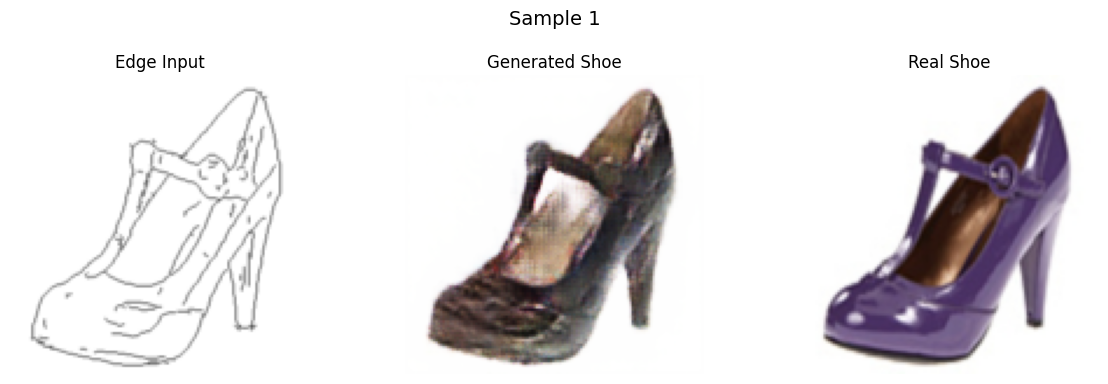

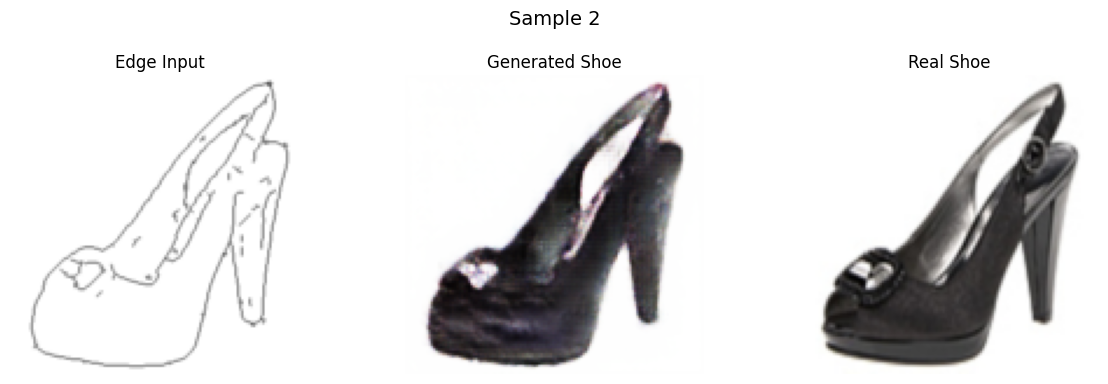

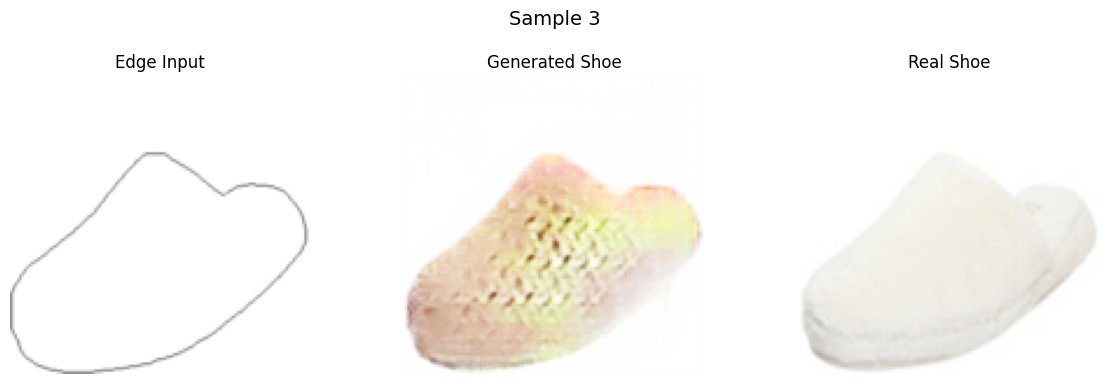

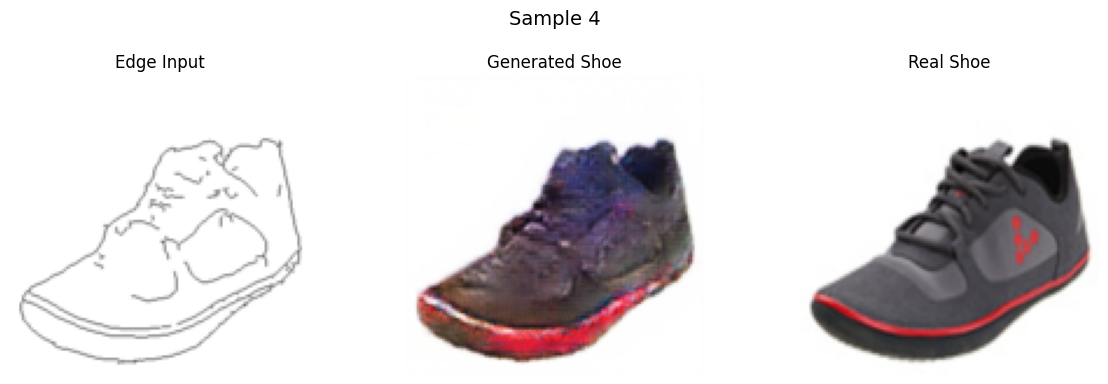

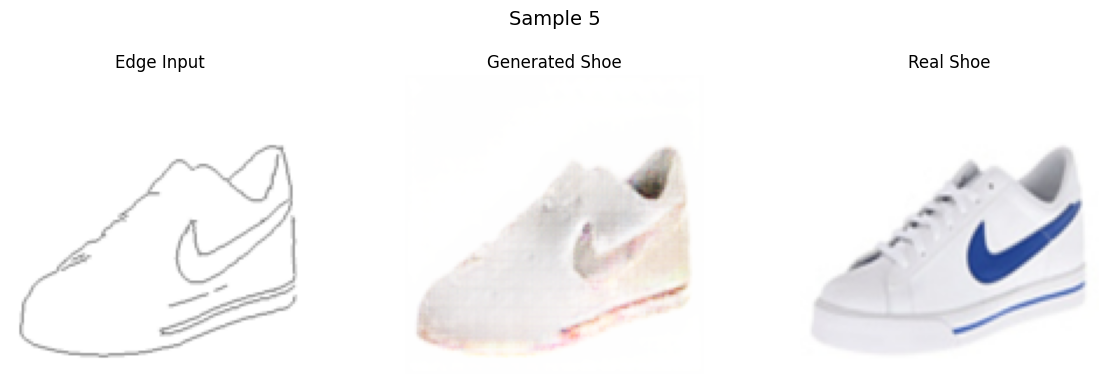

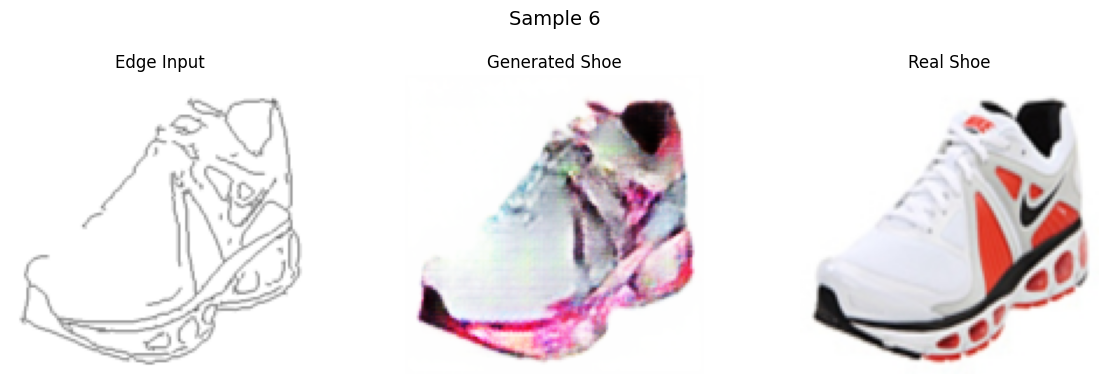

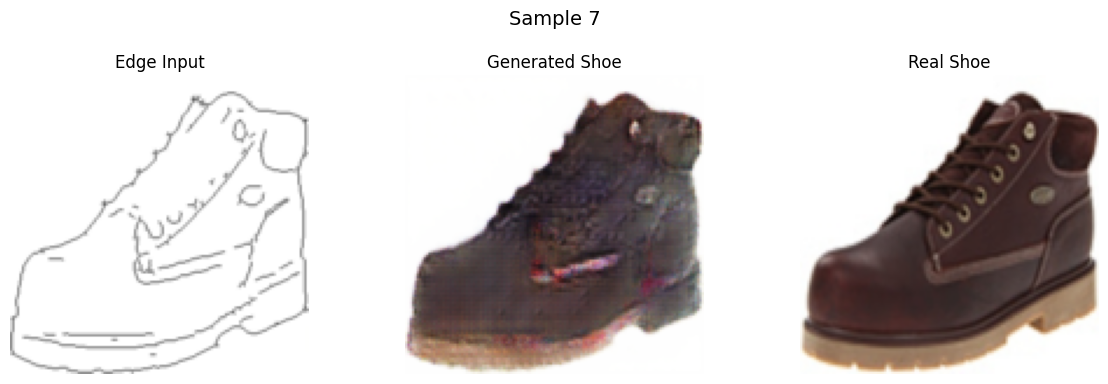

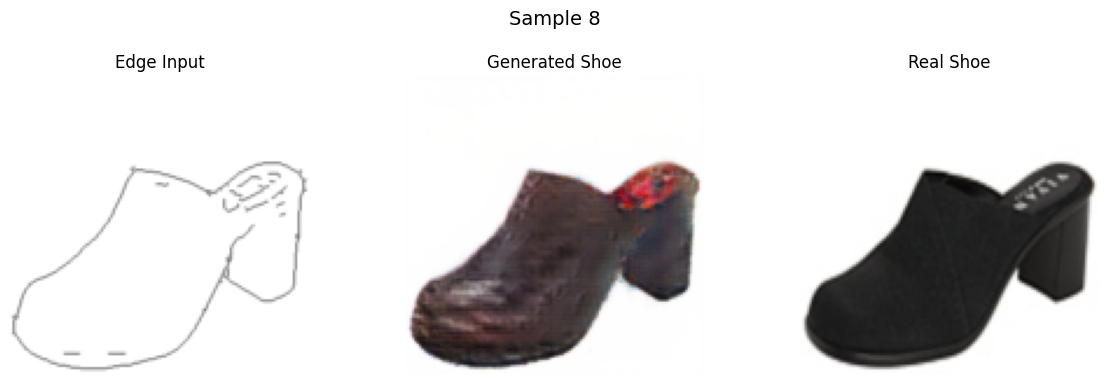

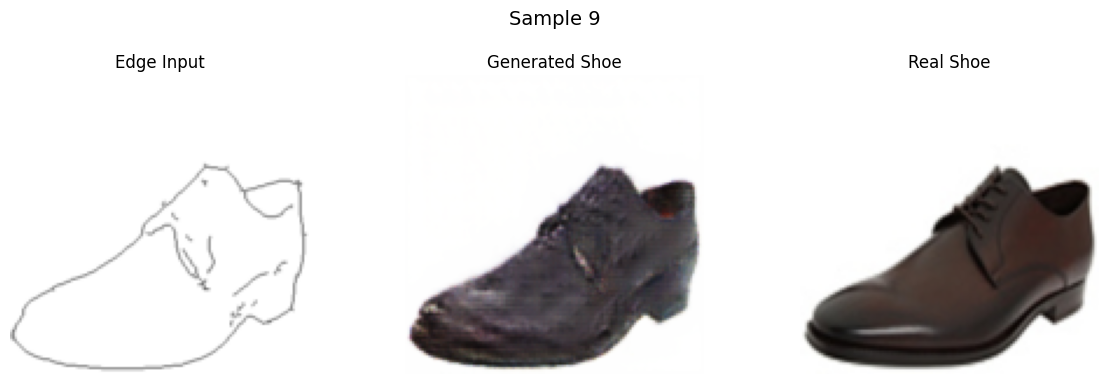

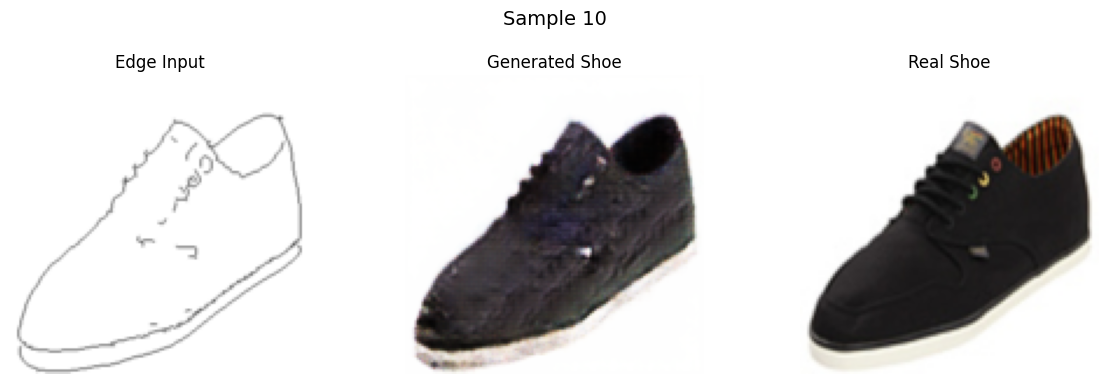


Plotting loss curves...


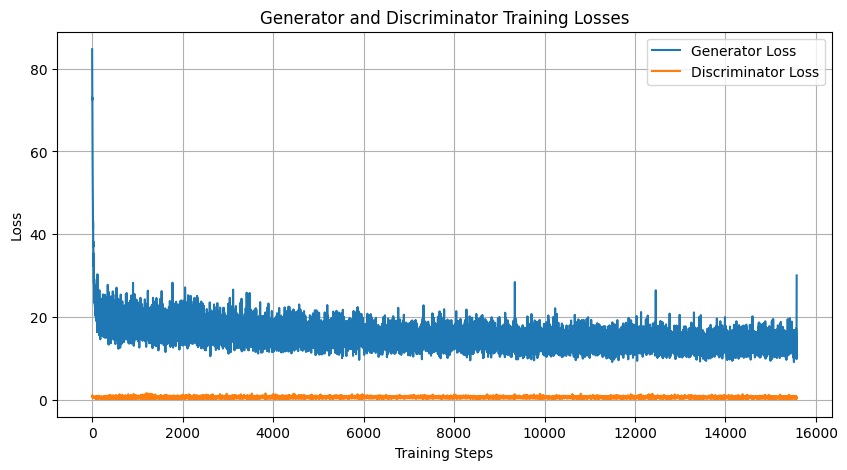

Evaluation and Visualization complete.


In [ ]:
# TODO: Set models to evaluation mode
generator.eval()
discriminator.eval() # Discriminator isn't strictly needed for inference but good practice

# TODO: Create function to denormalize images from [-1,1] to [0,1]
def denormalize(tensor):
  # Input tensor is expected to be in [-1, 1] range
  # Output tensor will be in [0, 1] range
  return (tensor + 1) / 2

# TODO: Create visualization function that:
#       - Takes several validation samples
#       - Generates fake shoes using trained generator
#       - Displays edge input, generated output, and real target
#       - Shows results in a grid format (3 columns: edge, generated, real)
def visualize_results(generator, dataloader, num_samples=10):
  generator.eval() # Ensure generator is in evaluation mode
  samples_shown = 0
  with torch.no_grad(): # No gradients needed for inference
    for i, (edge_imgs, real_shoes) in enumerate(dataloader):
      if samples_shown >= num_samples:
          break

      edge_imgs = edge_imgs.to(device)
      real_shoes = real_shoes.to(device)

      # Generate fake shoes
      fake_shoes = generator(edge_imgs)

      # Denormalize images
      edge_imgs_denorm = denormalize(edge_imgs)
      real_shoes_denorm = denormalize(real_shoes)
      fake_shoes_denorm = denormalize(fake_shoes)

      # Move back to CPU for visualization
      edge_imgs_cpu = edge_imgs_denorm.cpu().permute(0, 2, 3, 1).numpy()
      real_shoes_cpu = real_shoes_denorm.cpu().permute(0, 2, 3, 1).numpy()
      fake_shoes_cpu = fake_shoes_denorm.cpu().permute(0, 2, 3, 1).numpy()

      # Plotting
      for j in range(edge_imgs.size(0)):
          if samples_shown >= num_samples:
              break

          fig, axes = plt.subplots(1, 3, figsize=(12, 4))

          axes[0].imshow(edge_imgs_cpu[j])
          axes[0].set_title("Edge Input")
          axes[0].axis("off")

          axes[1].imshow(fake_shoes_cpu[j])
          axes[1].set_title("Generated Shoe")
          axes[1].axis("off")

          axes[2].imshow(real_shoes_cpu[j])
          axes[2].set_title("Real Shoe")
          axes[2].axis("off")

          plt.suptitle(f"Sample {samples_shown + 1}", fontsize=14)
          plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make space for suptitle
          plt.show()
          samples_shown += 1

# TODO: Display results for 10 validation samples
print("\nVisualizing validation results...")
visualize_results(generator, val_loader, num_samples=10)

# TODO: Plot training loss curves for generator and discriminator
print("\nPlotting loss curves...")
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Training Losses")
plt.plot(g_losses, label="Generator Loss")
plt.plot(d_losses, label="Discriminator Loss")
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

print("Evaluation and Visualization complete.")

## 🔟 Analysis

**Task**: Analyze your results

**Requirements**:
- Evaluate the quality of generated images
- Discuss strengths and limitations of your model
- Test the effect of different hyperparameters (optional)


In [ ]:
# TODO: Analyze the quality of generated shoes, for example:
#       - Are edges properly converted to realistic shoes?
#       - Do shoes maintain the shape from edge inputs?
#       - How realistic do the textures and colors look?
# TODO: Document any interesting observations or failure cases

TODO: Analyze the quality of generated shoes, for example:

      - Are edges properly converted to realistic shoes?

      - Do shoes maintain the shape from edge inputs?

      - How realistic do the textures and colors look?

TODO: Document any interesting observations or failure cases



### Analysis of Generated Shoes：


Based on the visualizations:

1.  **Edge Conversion and Shape Maintenance:**
    - The model generally succeeds in converting edge inputs into shoe images.
    - The generated shoes largely maintain the overall shape defined by the input edges. The U-Net architecture with skip connections helps in preserving spatial information and structure from the input edges.
    - Minor deviations in shape can occur, especially with intricate details or complex edge patterns.

2.  **Realism of Textures and Colors:**
    - The realism varies significantly. Some generated shoes have plausible textures and colors that resemble real shoes.
    - However, many generated images exhibit artifacts, blurriness, or unnatural textures and color distributions. The generated textures are often generic rather than detailed or specific to a shoe material (like leather or fabric).
    - The color generation can be inconsistent. Sometimes the generated colors look reasonable, while other times they appear patchy, oversaturated, or unrealistic. The model struggles to reproduce fine details or complex patterns found in real shoes.

### Interesting Observations:

- The L1 loss is crucial for maintaining the structural similarity between the generated image and the ground truth. Without it, the GAN might produce visually appealing but structurally inaccurate images. The balance between GAN loss and L1 loss (controlled by `LAMBDA_L1`) is a key hyperparameter.
- The PatchGAN discriminator, by classifying image patches, encourages the generator to produce high-frequency details and local realism, rather than just a globally convincing image.
- Training stability can be an issue with GANs. The loss curves might fluctuate significantly. Techniques like weight initialization and using Adam optimizers with specific beta values help, but hyperparameter tuning is often necessary for optimal results.
- The resolution (IMG_SIZE=128) limits the level of fine detail that can be generated. Higher resolutions would require more computational resources and potentially deeper or wider network architectures.

### Failure Cases:

- **Artifacts and Blurriness:** Many generated images show noticeable artifacts or a general lack of sharpness compared to the real images.
- **Color/Texture Inconsistencies:** The model sometimes generates unnatural or patchy colors/textures that don't match the expected shoe appearance.
- **Missing Fine Details:** Intricate details present in the ground truth shoes (like stitching, laces, logos) are often missing or poorly rendered in the generated images.
- **Mode Collapse (Potential):** While not explicitly observed as severe mode collapse in this limited sample, in GAN training, there's always a risk that the generator might only produce a limited variety of outputs.


## 📝 Evaluation Criteria

Your homework will be evaluated based on:

1. **Implementation Correctness (40%)**
   - Proper U-Net generator implementation
   - Correct PatchGAN discriminator
   - Working training loop with appropriate losses

2. **Training and Results (30%)**
   - Model trains without errors
   - Reasonable loss convergence
   - Generated images show edge-to-shoe translation

3. **Code Quality (20%)**
   - Clean, readable code with comments
   - Proper tensor shapes and data flow
   - Efficient implementation

4. **Analysis (10%)**
   - Discussion of results
   - Understanding of model behavior
   - Insights about GAN training